In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import Tree
np.random.seed(1)

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


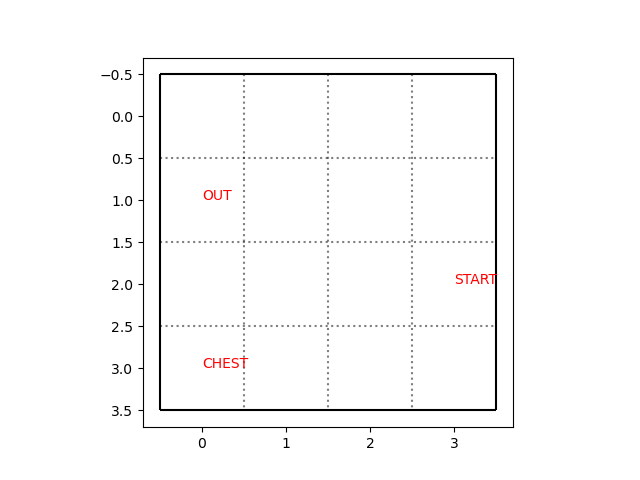

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [2]:
N_grid = 4
tree = Tree.Cell_Tree( N_grid )
tree.visu()


In [ ]:
fig, ax = plt.subplots()

ax.plot( np.arange( N_episodes ), np.exp(-exploration_decreasing_decay*np.arange( N_episodes )) )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [9]:
class Agent():
    def __init__(self, tree):  ### tree en input ?
        
        self.tree = tree ### the grid structure
    
        ### init Q-table
        self.N_state = self.tree.N_Wall+1 
        self.N_action = self.tree.N_Wall * 2
        self.Q_table = np.zeros(( self.N_state, self.N_action ))
        
        ### hyper params
        self.N_max_action = self.N_action*4
        ### Exploration
        self.exploration_proba = 1 ### init of the proba
        self.exploration_decreasing_decay = 0.005  ### decreasing decay for exponential decreasing
        self.min_exploration_proba = 0.01 ### Minimum of exploration proba

        if 0: self.N_episodes = 1000
        else : self.N_episodes = np.ceil( np.log( self.min_exploration_proba ) / -self.exploration_decreasing_decay ).astype(int)
        #print( 'N_episodes ',N_episodes )

        self.discount = 0.9 ### Discounted factor : gamma or discount
        self.lr = 0.9 ### learning rate or alpha

        ### Metrics
        self.total_rewards_episode = np.zeros( self.N_episodes )
          
    def train(self):
        ### we iterate over episodes
        for e in range(self.N_episodes): 

            if not(e%100):
                print( e,'/', self.N_episodes )

            ### we initialize the first state of the episode
            current_state = 0 ### START state OUT ACCESSIBLE
            self.tree.reset_tree()
            #done = False

            #sum the rewards that the agent gets from the environment
            total_episode_reward = 0

            for i in range(self.N_max_action): 
                ### we sample a float from a uniform distribution over 0 and 1
                # if the sampled float is less than the exploration proba
                #     the agent selects arandom action
                # else
                #     he exploits his knowledge using the bellman equation 

                if np.random.uniform(0,1) < self.exploration_proba:

                    action = self.__sample_action()
                else:
                    action = np.argmax(self.Q_table[current_state,:])

                # The environment runs the chosen action and returns
                # the next state, a reward and true if the epiosed is ended.
                next_state, reward, done = self.__step( action, current_state)

                # We update our Q-table using the Q-learning iteration
                self.Q_table[current_state, action] = (1-self.lr)*self.Q_table[current_state, action] + self.lr*(reward + self.discount*max(self.Q_table[next_state,:]))

                total_episode_reward = total_episode_reward + reward
                # If the episode is finished, we leave the for loop
                if done:
                    print( 'HERE WE BREAK' )
                    break
                current_state = next_state
            #We update the exploration proba using exponential decay formula 
            self.exploration_proba = max(self.min_exploration_proba, np.exp(-self.exploration_decreasing_decay*e))
            self.total_rewards_episode[e] = total_episode_reward
            
    def generate(self):
        
        ### we initialize the first state of the episode
        current_state = 0 ### START state OUT ACCESSIBLE
        self.tree.reset_tree()

        #sum the rewards that the agent gets from the environment
        total_episode_reward = 0

        for i in range(self.N_max_action): 

            action = np.argmax(self.Q_table[current_state,:])

            # The environment runs the chosen action and returns
            # the next state, a reward and true if the epiosed is ended.
            next_state, reward, done = self.__step( action, current_state)

            total_episode_reward = total_episode_reward + reward
            # If the episode is finished, we leave the for loop

            current_state = next_state
            
    def __sample_action( self ):
        return np.random.randint( self.N_action )
    
    def __step( self, action, current_state ):
    
        maze_state_before_action = self.tree.check() ### store before action state to compare with the post action one
        is_action_done = self.__do_action( action )  ### perform the action on the maze
        new_state = self.__get_state()
        reward = self.__get_reward( is_action_done, current_state, maze_state_before_action )

        done = False
        #if new_state == 2:
        #    done =True

        return new_state, reward, done
    
    def __do_action( self, Wall_ID ):
        ### build or brake the wall
        ### return True if the action has been done

        if Wall_ID < self.tree.N_Wall: ### CONSTRUCTION
            if self.tree.Wall_state[Wall_ID] :
                return False ###Wall already built
            else :
                self.tree.build_WALL( Wall_ID )
                return True
        else: ###DESTRUCTION
            Wall_ID_tmp = Wall_ID-self.tree.N_Wall ### 'real' Wall ID
            if self.tree.Wall_state[Wall_ID_tmp] :
                self.tree.brake_WALL( Wall_ID_tmp )
                return True 
            else :
                return False ### Wall already built
            
    def __get_state(self):
        if 1:
            ### the status is the number of Walls build
            return self.tree.Wall_state.sum() 
        
    def __get_reward( self, is_action_done, current_state, maze_state_before_action ):
    
        Reward=0
        #new_state = get_state( tree ) ### NOT TAKE INTO ACCOUNT ??!!??
        maze_state_after_action = tree.check()
        
        if 1:
            if is_action_done:
                Reward += 0 ### reward for having done a do-able action
            else:
                Reward += -0 ### penality for non do-able action
            if maze_state_after_action:
                Reward += 0   ### reward for a do-able maze
            else:
                Reward += -1  ### penality for non-doable maze

            if not( maze_state_before_action ) and maze_state_after_action: 
                Reward += 1   ### reward for fixing a broken maze
        return Reward



In [10]:
agent = Agent(tree)

In [11]:
agent.train()

0 / 922
100 / 922
200 / 922
300 / 922
400 / 922
500 / 922
600 / 922
700 / 922
800 / 922
900 / 922


<IPython.core.display.Javascript object>


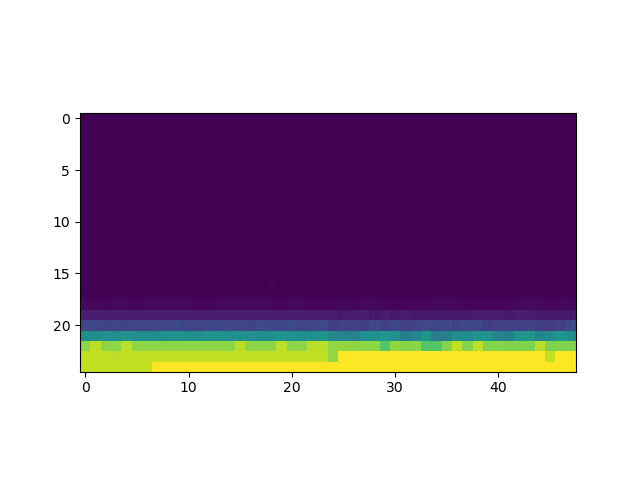

In [25]:
fig, ax = plt.subplots()

ax.imshow( (agent.Q_table) )

<IPython.core.display.Javascript object>


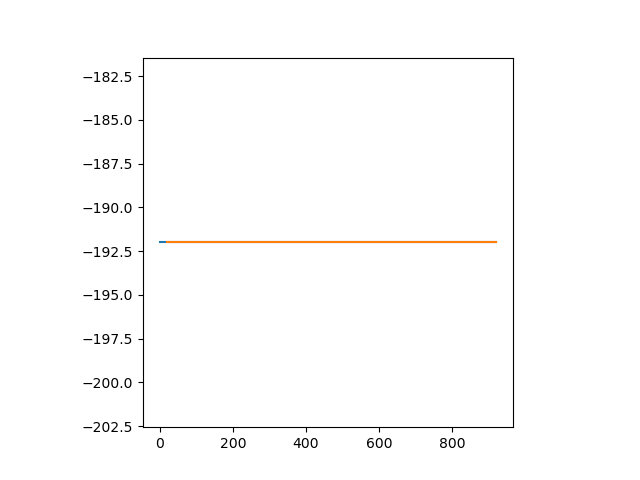

In [14]:
fig, ax = plt.subplots()

ax.plot( np.arange( agent.N_episodes ), agent.total_rewards_episode )

kernel = 20
moy_roulante = np.convolve( agent.total_rewards_episode , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1,agent.N_episodes  ), moy_roulante )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

False


<IPython.core.display.Javascript object>


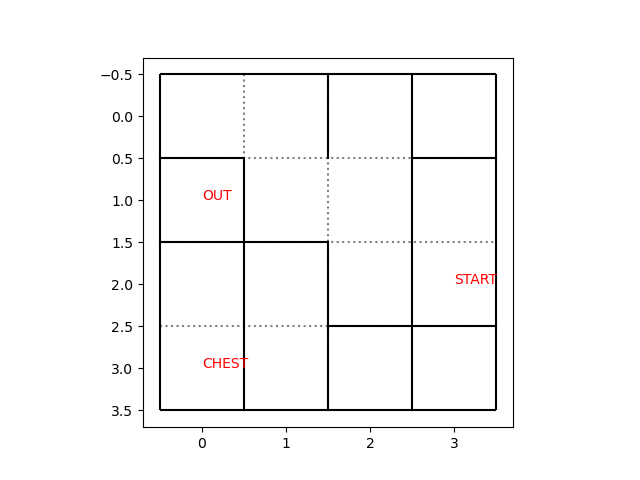

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [15]:
print( tree.check() )
tree.visu()

In [19]:
agent.generate()

False


<IPython.core.display.Javascript object>


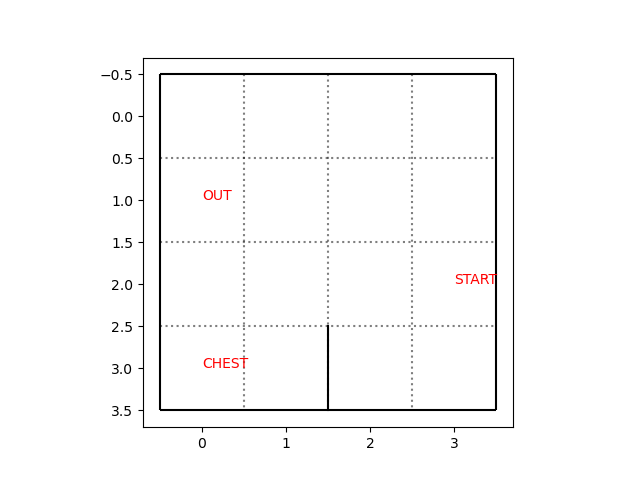

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [20]:
print( tree.check() )
tree.visu()

In [ ]:
    
def do_action( Wall_ID, tree ):
    ### build or brake the wall
    ### retuen True if the action have been done
    
    if Wall_ID < tree.N_Wall: ### CONSTRUCTION
        if tree.Wall_state[Wall_ID] :
            return False ###Wall already built
        else :
            tree.build_WALL( Wall_ID )
            return True
    else: ###DESTRUCTION
        Wall_ID_tmp = Wall_ID-tree.N_Wall ### 'real' Wall ID
        if tree.Wall_state[Wall_ID_tmp] :
            tree.brake_WALL( Wall_ID_tmp )
            return True 
        else :
            return False ### Wall already built
                
def sample_action( N_action ):
    return np.random.randint(N_action)

def step( tree, action, current_state ):
    
    maze_state_before_action = tree.check
    
    is_action_done = do_action( action, tree )
    
    new_state = get_state( tree )
    
    reward = get_reward( tree, is_action_done, current_state, maze_state_before_action )
    
    done = False
    #if new_state == 2:
    #    done =True
    
    return new_state, reward, done
    
def get_state( tree ):
    if 1:
        ### the status is the number of Wall build
        return tree.Wall_state.sum() 
    
def get_reward( tree, is_action_done, current_state, maze_state_before_action ):
    
    Reward=0

    state = get_state( tree )
    
    if 1:
        if is_action_done:
            Reward += 0.1 ### reward for having done a doable action
            
        if tree.check():
            Reward += 0   ### reward for a doable maze
        else:
            Reward += -1  ### panality for un-doable maze
            
        if not( maze_state_before_action ) and tree.check(): 
            Reward += 1   ### reward for fixing a broken maze

            
    return Reward


In [ ]:
### we iterate over episodes
for e in range(N_episodes): 
    
    if not(e%100):
        print( e,'/',N_episodes )

    ### we initialize the first state of the episode
    current_state = 0 ### START state OUT ACCESSIBLE
    tree.reset_tree()
    done = False
    
    #sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    
    for i in range(N_max_action): 
        ### we sample a float from a uniform distribution over 0 and 1
        # if the sampled float is less than the exploration proba
        #     the agent selects arandom action
        # else
        #     he exploits his knowledge using the bellman equation 
        
        if np.random.uniform(0,1) < exploration_proba:
            
            action = sample_action( N_action )
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, reward, done = step(tree, action, current_state)
        
        # We update our Q-table using the Q-learning iteration
        Q_table[current_state, action] = (1-lr)*Q_table[current_state, action] +lr*(reward + discount*max(Q_table[next_state,:]))
                
        total_episode_reward = total_episode_reward + reward
        # If the episode is finished, we leave the for loop
        if done:
            print( 'HERE WE BREAK' )
            break
        current_state = next_state
    #We update the exploration proba using exponential decay formula 
    exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    total_rewards_episode[e] = total_episode_reward

In [ ]:
Q_table

In [ ]:
fig, ax = plt.subplots()

ax.imshow( Q_table )

In [ ]:
fig, ax = plt.subplots()

ax.plot( np.arange( N_episodes ), total_rewards_episode )

kernel = 20
moy_roulante = np.convolve( total_rewards_episode , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1,N_episodes  ), moy_roulante )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [ ]:
tree.check()

In [ ]:
tree.check()
tree.visu()